In [ ]:
!pip install transformers accelerate datasets diffusers Pillow==9.4.0

# Load MNIST

In [1]:
from datasets import load_dataset, Dataset, DatasetDict

ds = load_dataset("uoft-cs/cifar10")

In [2]:
ds["train"]

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})

In [3]:
d=ds["train"][0]
d

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 0}

# Load DCAE

In [4]:
import torch
from diffusers import AutoencoderDC
from transformers import Gemma2Model, GemmaTokenizerFast

model = "Efficient-Large-Model/Sana_600M_1024px_diffusers"
dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

dcae = AutoencoderDC.from_pretrained(model, subfolder="vae", torch_dtype=dtype).to(device)

# PIL to latent

In [11]:
import torchvision.transforms as T

def encode_pil(image, ae):
    # MNIST inputs are grayscale/BW
    image = image.convert('RGB')
    transform = T.Compose([
        T.Resize(64, antialias=True),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        lambda x: x.to(dtype=torch.bfloat16)
    ])

    image_tensor = transform(image)[None].to(device)

    with torch.no_grad():
        latent = ae.encode(image_tensor)
    return latent.latent

latent = encode_pil(d["img"], dcae)
latent.shape

torch.Size([1, 32, 2, 2])

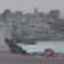

In [12]:
from utils import latent_to_PIL
latent_to_PIL(latent, dcae)

# Process CIFAR10 and upload

In [14]:
from tqdm import tqdm

dataset_latents = {}
splits = ["train", "test"]

for split in splits:
    print(split)
    dataset_latents[split]=[]
    
    for d in tqdm(ds[split]):
        pil, label = d["img"], d["label"]
        latent = encode_pil(pil, dcae).float().cpu()
        dataset_latents[split].append({
            "label": label,
            "latent": latent.numpy()
        })

train


100%|█████████████████████████████████████| 50000/50000 [09:24<00:00, 88.54it/s]


test


100%|█████████████████████████████████████| 10000/10000 [01:53<00:00, 88.33it/s]


In [15]:
dataset = DatasetDict({split: Dataset.from_list(dataset_latents[split]) for split in splits})
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'latent'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['label', 'latent'],
        num_rows: 10000
    })
})

In [16]:
dataset.push_to_hub("g-ronimo/CIFAR10-64-latents_dc-ae-f32c32-sana-1.0", private=True, commit_message=model)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/50 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/g-ronimo/CIFAR10-64-latents_dc-ae-f32c32-sana-1.0/commit/84eef69e3c1cffccacac8efb2363e58a55f3142c', commit_message='Efficient-Large-Model/Sana_600M_1024px_diffusers', commit_description='', oid='84eef69e3c1cffccacac8efb2363e58a55f3142c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/g-ronimo/CIFAR10-64-latents_dc-ae-f32c32-sana-1.0', endpoint='https://huggingface.co', repo_type='dataset', repo_id='g-ronimo/CIFAR10-64-latents_dc-ae-f32c32-sana-1.0'), pr_revision=None, pr_num=None)